# Clustering

# 2. K-means vs Gaussian Mixture

In this lab, you will compare K-means and the Gaussian Mixture Model (GMM) on the [Iris dataset](https://fr.wikipedia.org/wiki/Iris_de_Fisher). Feel free to use any dataset of your choice.

## Imports

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns

In [3]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [4]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples
from sklearn.metrics.cluster import contingency_matrix

## Data

In [5]:
iris = datasets.load_iris()
X = iris.data  
y = iris.target
feature_names = iris.feature_names
label_names = iris.target_names

In [6]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
print(label_names)

['setosa' 'versicolor' 'virginica']


In [8]:
def show_data(X, y, features=[0, 1], feature_names=feature_names):
    '''Display the samples in 2D'''
    plt.figure(figsize=(5,5))
    for label in set(y):
        plt.scatter(X[y == label, features[0]], X[y == label, features[1]])
    plt.xlabel(feature_names[features[0]])
    plt.ylabel(feature_names[features[1]])
    plt.show()

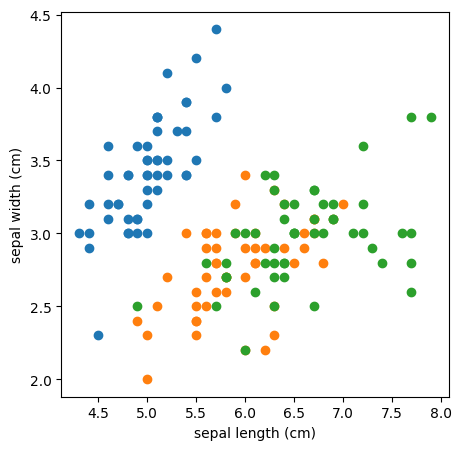

In [9]:
show_data(X, y, [0, 1])

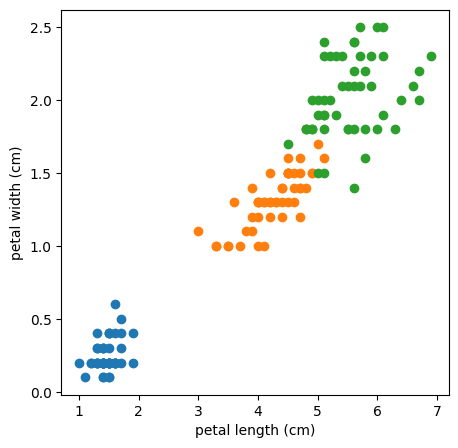

In [10]:
show_data(X, y, [2, 3])

## K-means

We first apply k-means and display the clusters.

In [11]:
n_clusters = 3
km = KMeans(n_clusters, n_init=10)
labels = km.fit_predict(X)

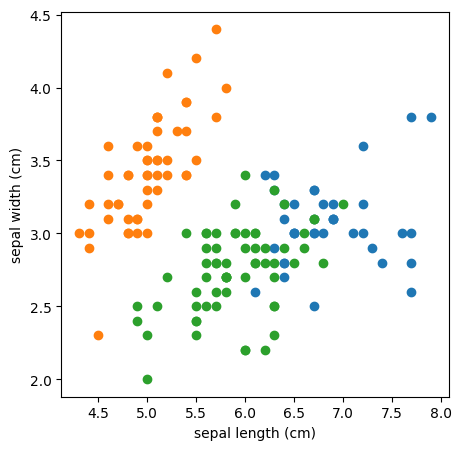

In [12]:
show_data(X, labels, [0, 1])

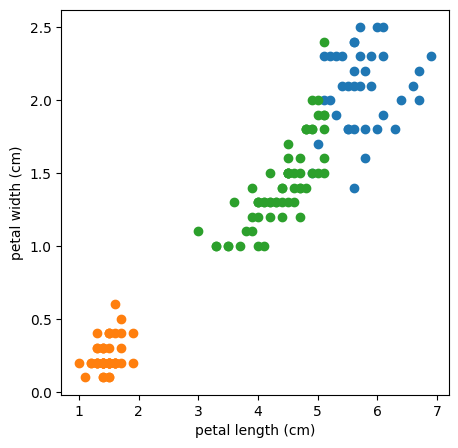

In [13]:
show_data(X, labels, [2, 3])

## Gaussian Mixture Model

We now compare with the Gaussian Mixture Model.

In [14]:
gm = GaussianMixture(n_clusters)
labels_ = gm.fit_predict(X)

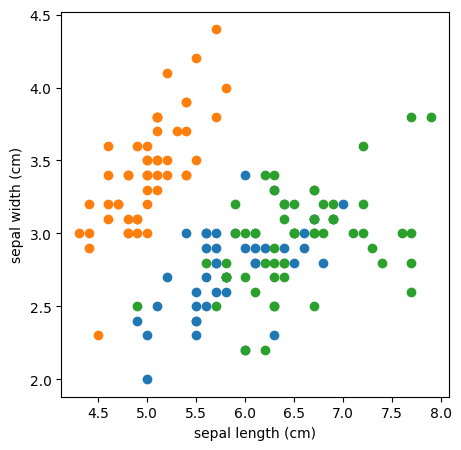

In [15]:
show_data(X, labels_, [0, 1])

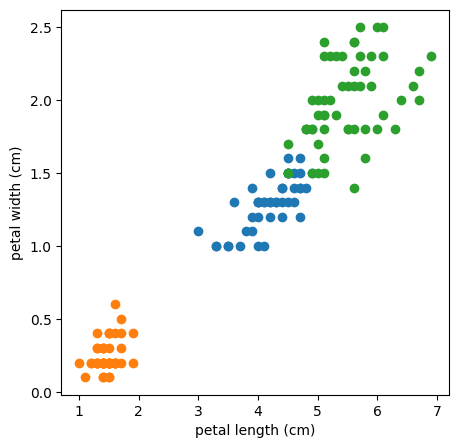

In [16]:
show_data(X, labels_, [2, 3])

## To do

* Display the contigency matrix for each clustering. Which one looks better?
* Confirm your guess using the ARI and AMI scores.
* Check that the optimal number of clusters is 3.
* Is it possible to guess the optimal number of clusters with the silhouette scores?<br>
Interpret the results.

#### Contigency matrix :

<font color='#A62D16'>K-means :</font>

In [17]:
kmeans_contingency = contingency_matrix(y, labels)

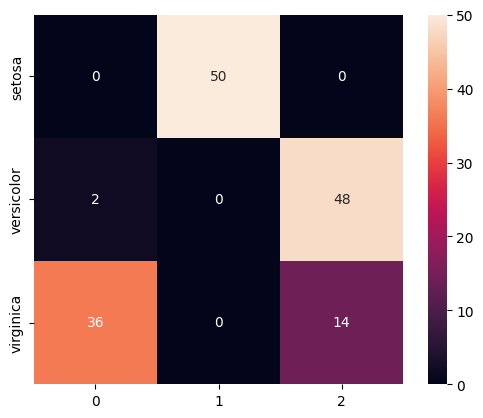

In [18]:
sns.heatmap(kmeans_contingency, annot=True, square=True, xticklabels=np.arange(n_clusters), yticklabels=label_names);

<font color='#137538'>Gaussian Mixture Model :</font>

In [19]:
gmm_contingency = contingency_matrix(y, labels_)

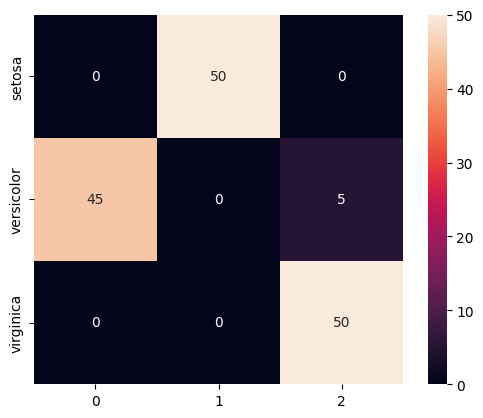

In [20]:
sns.heatmap(gmm_contingency, annot=True, square=True, xticklabels=np.arange(n_clusters), yticklabels=label_names);

The Gaussian Mixture Model method looks better. We can confirm this by using the **Purity** metric.

The **Purity** metric is defined as:

$$
\text{Purity} = \frac{1}{N} \sum_{k=1}^{K} \max_j \, n_{kj}
$$

where:

- \( $N$ \) — total number of samples  
- \( $K$ \) — number of clusters  
- \( $n_{kj}$ \) — number of samples of true class \( j \) assigned to cluster \( k \)  
- \( $\displaystyle \max_{j} \, n_{kj}$ \) — number of samples in cluster \( k \) belonging to its dominant true class

In [21]:
kmeans_purity = np.sum(np.amax(kmeans_contingency, axis=1)) / np.sum(kmeans_contingency)
gmm_purity = np.sum(np.amax(gmm_contingency, axis=1)) / np.sum(gmm_contingency)

print(f"K-means Purity : {kmeans_purity:.3f}")
print(f"GMM Purity : {gmm_purity:.3f}")

K-means Purity : 0.893
GMM Purity : 0.967


#### ARI and AMI scores :

Let's confirm this by calculating the **ARI** and **AMI** scores :

<font color='#3C25B3'><b>What is the Adjusted Rand Index (ARI)?</b></font>

The ARI measures how similar two clusterings are — typically :
- the true labels (ground truth), and
- the predicted clusters (from our algorithm).

It is based on pair counting — looking at all pairs of samples and checking whether each pair is :
- in the same cluster in both labelings, or
- in different clusters in both labelings.

Imagine taking every possible pair of data points:
- If two points belong to the same true class and the same predicted cluster → agreement ✅
- If two points belong to different true classes and different predicted clusters → agreement ✅
- Otherwise → disagreement ❌

The **Rand Index (RI)** is simply the fraction of agreements among all pairs. The **Adjusted Rand Index (ARI)** corrects the Rand Index for chance —
so that random clusterings have a score near 0, not an artificially high value.

Let $n_{ij}$ be the number of elements that are in **true class i** and in **predicted cluster j**.

Let's define :
- $a_i = \sum_j n_{ij}$ → total in true class i
- $b_j = \sum_i n_{ij}$ → total in predicted class j

$$
\text{ARI} = 
\frac{
\sum_{ij} \binom{n_{ij}}{2}
- 
\left[ 
\sum_i \binom{a_i}{2} 
\sum_j \binom{b_j}{2} 
\right] 
\Big/ 
\binom{N}{2}
}{
\frac{1}{2} 
\left[
\sum_i \binom{a_i}{2} 
+ 
\sum_j \binom{b_j}{2}
\right]
- 
\left[
\sum_i \binom{a_i}{2} 
\sum_j \binom{b_j}{2}
\right]
\Big/ 
\binom{N}{2}
}
$$

Where :
- \( $N$ \) — total number of samples  
- $\binom{n}{2} = \frac{n(n-1)}{2}$

| ARI Score Range | Interpretation |
|-----------------|----------------|
| 1.0             | Perfect clustering : predicted clusters match true labels exactly |
| 0.8 – 1.0       | Very strong agreement between clustering and true labels |
| 0.5 – 0.8       | Good agreement between clustering and true labels |
| 0.0 – 0.5       | Weak agreement; clustering is somewhat aligned with true labels |
| < 0.0           | Worse than random; no agreement with true labels |

<font color='#BA2525'><b>What is the Adjusted Mutual Information (AMI)?</b></font>

**Mutual Information** measures how much information one random variable contains about another. In clustering :

- Let $U = \{U_1, U_2, \dots, U_r\}$ be the set of clusters found by an algorithm.
- Let $V = \{V_1, V_2, \dots, V_s\}$ be the set of true classes (ground truth).

The **Mutual Information** between **U** and **V** is :
$$
MI(U, V) = \sum_{i=1}^{r} \sum_{j=1}^{s} P(U_i \cap V_j) \times \log \frac{P(U_i \cap V_j)}{P(U_i) P(V_j)}
$$

Where :

- $P(U_i)$ = fraction of points in the cluster $U_i$.
- $P(V_j)$ = fraction of points in the class $V_j$.
- $P(U_i \cap V_j)$ = fraction of points in both $U_i$ and $V_j$.

**MI** can be inflated by chance. For example : If we randomly assign points to clusters, MI might still be non-zero, especially if the number of clusters is large.

Let's define **H(U)** to be the entropy of the clustering, and **H(V)** to be the entropy of the ground truth (true classes).

$$ H(U) = - \sum_{i=1}^{r} P(U_i) \times \log P(U_i) $$

$$ H(V) = - \sum_{j=1}^{s} P(V_j) \times \log P(V_j) $$

**The Adjusted Mutual Information (AMI)** corrects MI for the expected agreement due to chance. It is defined as :

$$ AMI(U, V) = \frac{MI(U, V) - \mathbb{E}[MI(U, V)]}{\max(H(U), H(V)) - \mathbb{E}[MI(U, V)]} $$

Where $\mathbb{E}[MI(U, V)]$ is the expected mutual information of random clusterings with the same cluster sizes.

Range of **AMI** : $[-1,1]$ :
- 1 → perfect agreement
- 0 → random agreement
- Negative → worse than random (rare)

In [22]:
kmeans_ari = adjusted_rand_score(y, labels)
kmeans_ami = adjusted_mutual_info_score(y, labels)

gmm_ari = adjusted_rand_score(y, labels_)
gmm_ami = adjusted_mutual_info_score(y, labels_)

print(f"K-means ARI : {kmeans_ari:.3f}")
print(f"GMM ARI : {gmm_ari:.3f}")

print(f"\nK-means AMI : {kmeans_ami:.3f}")
print(f"GMM AMI : {gmm_ami:.3f}")

K-means ARI : 0.730
GMM ARI : 0.904

K-means AMI : 0.755
GMM AMI : 0.898


Using the ARI and the AMI scores, we can confirm that the Gaussian Mixture Model (GMM) method is better than the K-means method.

#### The optimal number of clusters :

There are various methods to find the optimal number of clusters :
- Maximize the ARI and AMI scores.
- Find the elbow (usually the inertia).
- Maximize the Silhouette score.

<font color='#388A28'><b>ARI and AMI scores :</b></font>

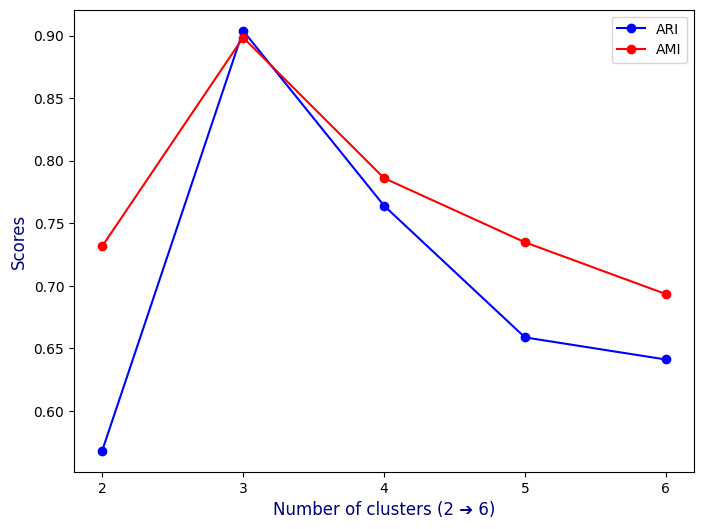

In [23]:
# Select the optimal number of clusters : ARI, AMI
ARI = []
AMI = []

for i in range(2,7):
    gm = GaussianMixture(n_components=i, n_init=10)
    labels_ = gm.fit_predict(X)
    ARI.append(adjusted_rand_score(y, labels_))
    AMI.append(adjusted_mutual_info_score(y, labels_))
    
fig = plt.figure(figsize=(8,6))

plt.plot([i for i in range(2, 7)], ARI, color='blue', marker="o", label='ARI')
plt.plot([i for i in range(2, 7)], AMI, color='red', marker="o", label='AMI')

plt.xlabel("Number of clusters (2 ➔ 6)", color='navy', fontsize=12)
plt.ylabel("Scores", color='navy', fontsize=12)

plt.xticks(list(range(2, 7)))

plt.legend()

plt.show()

The optimal number of clusters is 3.

<font color='#388A28'><b>Silhouette score :</b></font>

The **Silhouette score** measures how well each point fits into its assigned cluster compared to other clusters.

For a given point i :
- **a(i)** = average distance to all other points in the same cluster (intra-cluster distance) → cohesion
- **b(i)** = average distance to all points in the nearest other cluster → separation

For a point i, the silhouette score is defined by :

$$ s(i) = \frac{b(i) - a(i)}{\max \{ a(i), b(i) \}} $$

Interpretation of this score :
- if **b(i)** ≫ **a(i)**, then **s(i)** ≈ 1 → well-clustered
- if **b(i)** ≈ **a(i)**, then **s(i)** ≈ 0 → on boundary
- if **b(i)** < **a(i)**, then **s(i)** < 0 → misclassified

The overall score for the clustering is the average over all points :
$$ S = \frac{1}{n} \sum_{i=1}^{n} s(i) $$

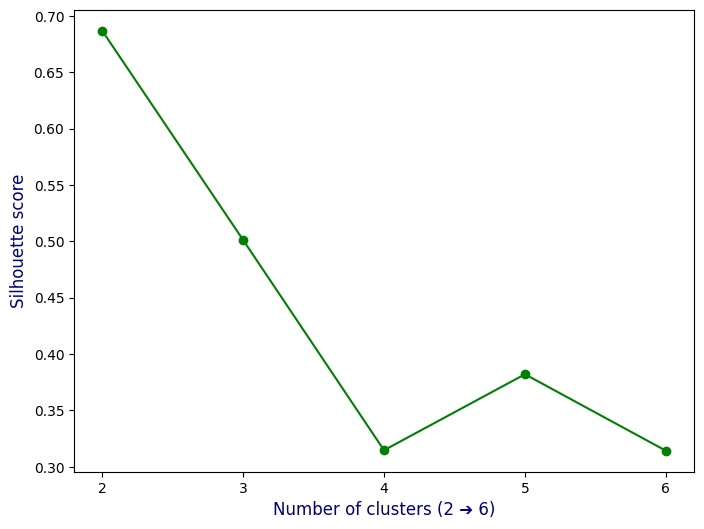

In [24]:
# Select the optimal number of clusters : Silhouette score
silhouette_scores = []

for i in range(2,7):
    gm = GaussianMixture(n_components=i, n_init=10)
    labels_ = gm.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels_))
    
fig = plt.figure(figsize=(8,6))

plt.plot([i for i in range(2, 7)], silhouette_scores, color='green', marker="o")

plt.xlabel("Number of clusters (2 ➔ 6)", color='navy', fontsize=12)
plt.ylabel("Silhouette score", color='navy', fontsize=12)

plt.xticks(list(range(2, 7)))

plt.show()

If we rely on the silhouette score, the optimal number of clusters is 2 and not 3.

In fact, the **Silhouette score** is an internal clustering validation metric, meaning no ground-truth labels are needed. It measures how similar a point is to its own cluster compared to other clusters.

The **ARI** and **AMI** scores are external clustering validation metrics, meaning we need ground-truth labels (true classes) to compute them. They measure how well our clustering matches the true labels.

Let's assume that the number of clusters is 3.

In [25]:
n_clusters = 3

Let's display the silhouette distribution of each cluster :

In [26]:
gm = GaussianMixture(n_components=n_clusters, n_init=10)
labels_ = gm.fit_predict(X)

In [27]:
# Silhouette scores
df_silhouette = pd.DataFrame(data= np.c_[X, label_names[y], labels_, silhouette_samples(X, labels_)],
                             columns= iris['feature_names'] + ['target'] + ['cluster'] + ['silhouette'])

df_silhouette['target'] = df_silhouette['target'].astype(str)
df_silhouette['cluster'] = df_silhouette['cluster'].astype(int)

# Columns to exclude
exclude_cols = ['target', 'cluster']

# Convert all other columns to float64
for col in df_silhouette.columns:
    if col not in exclude_cols:
        df_silhouette[col] = df_silhouette[col].astype(float)

df_silhouette = df_silhouette.sort_values('silhouette', ascending=False)

df_silhouette

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,cluster,silhouette
7,5.0,3.4,1.5,0.2,setosa,1,0.843627
0,5.1,3.5,1.4,0.2,setosa,1,0.842852
49,5.0,3.3,1.4,0.2,setosa,1,0.841863
17,5.1,3.5,1.4,0.3,setosa,1,0.840756
39,5.1,3.4,1.5,0.2,setosa,1,0.839662
...,...,...,...,...,...,...,...
119,6.0,2.2,5.0,1.5,virginica,0,-0.104425
70,5.9,3.2,4.8,1.8,versicolor,0,-0.112496
52,6.9,3.1,4.9,1.5,versicolor,2,-0.120586
68,6.2,2.2,4.5,1.5,versicolor,0,-0.343793


In [28]:
overall_silhouette_score = silhouette_score(X, labels_)
print(f"Silhouette score : {overall_silhouette_score:.3f}")

Silhouette score : 0.501


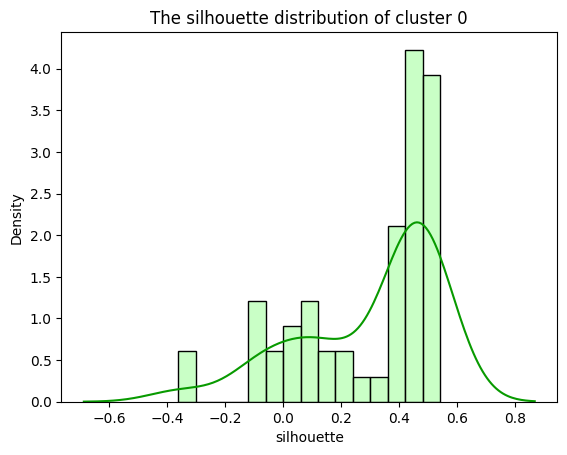

In [29]:
silhouette_0 = df_silhouette.loc[df_silhouette['cluster']==0, 'silhouette']

sns.histplot(silhouette_0, color='#B7FFB3', bins=15, stat='density')
sns.kdeplot(silhouette_0, color='#089A00')

plt.title('The silhouette distribution of cluster 0')

plt.show()

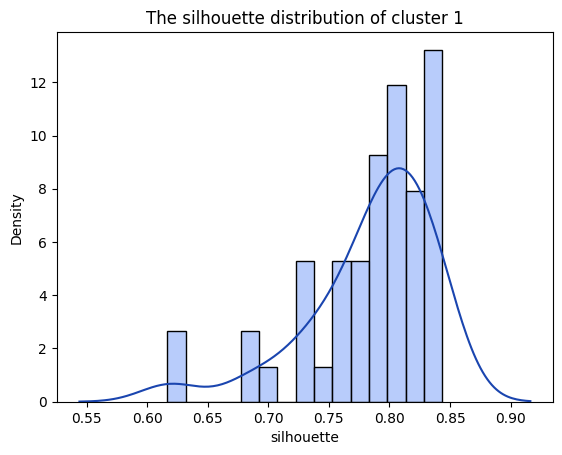

In [30]:
silhouette_1 = df_silhouette.loc[df_silhouette['cluster']==1, 'silhouette']

sns.histplot(silhouette_1, color='#A1BBFA', bins=15, stat='density')
sns.kdeplot(silhouette_1, color='#1A45AF')

plt.title('The silhouette distribution of cluster 1')

plt.show()

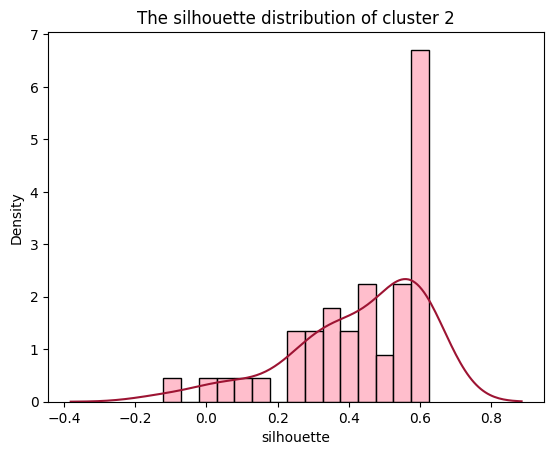

In [31]:
silhouette_2 = df_silhouette.loc[df_silhouette['cluster']==2, 'silhouette']

sns.histplot(silhouette_2, color='#FFA8BC', bins=15, stat='density')
sns.kdeplot(silhouette_2, color='#9D1433')

plt.title('The silhouette distribution of cluster 2')

plt.show()

In [32]:
avg_silhouette_per_cluster = df_silhouette.groupby('cluster')['silhouette'].mean()
print(avg_silhouette_per_cluster)

cluster
0    0.302522
1    0.784421
2    0.429259
Name: silhouette, dtype: float64


The best cluster is the cluster 1, and the worst one is the cluster 0.

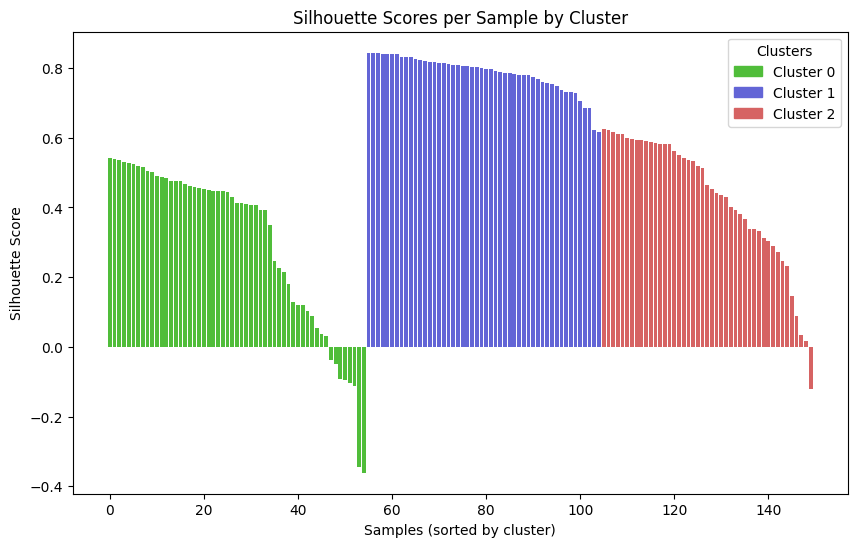

In [33]:
cluster_colors = {
    0: '#50BD3A',  # green
    1: '#6365D6',  # blue
    2: '#D66363'   # red
}

# Sort the dataframe by cluster to make the plot neat
df_silhouette_sorted = df_silhouette.sort_values(['cluster', 'silhouette'], ascending=[True, False])

# Create a color list for plotting
colors = df_silhouette_sorted['cluster'].map(cluster_colors)

# Plot silhouette scores per sample
plt.figure(figsize=(10,6))
plt.bar(range(len(df_silhouette_sorted)), df_silhouette_sorted['silhouette'], color=colors)
plt.xlabel('Samples (sorted by cluster)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores per Sample by Cluster')

# Add legend
patches = [mpatches.Patch(color=color, label=f'Cluster {cluster}') 
           for cluster, color in cluster_colors.items()]
plt.legend(handles=patches, title='Clusters')

plt.show()

## Variants

Some constraints can be added on the covariance matrices so as to make the model simpler and less prone to overfitting.

In [34]:
n_clusters=3

gmm_models = {
    'full': GaussianMixture(n_components=n_clusters, covariance_type='full', n_init=10, random_state=42),
    'tied': GaussianMixture(n_components=n_clusters, covariance_type='tied', n_init=10, random_state=42),
    'diag': GaussianMixture(n_components=n_clusters, covariance_type='diag', n_init=10, random_state=42),
    'spherical': GaussianMixture(n_components=n_clusters, covariance_type='spherical', n_init=10, random_state=42)
}

## To do 

* Test the various types of covariance matrices and interpret the results.
* Redo the experiments with a scaling factor of 10 on ones of the 4 components and interpret the results.

Let's calculate the three scores (ARI, AMI, and Silhouette) for each model :

In [35]:
def evaluate_gmm_models(X, y):
    """
    Evaluate a dictionary of Gaussian Mixture Models on clustering performance.

    Parameters:
        X (array-like): Feature matrix.
        y (array-like): True labels.

    Returns:
        pd.DataFrame: DataFrame with Covariance Type, ARI, AMI, and Silhouette scores.
    """
    results = []
    
    for cov_type, model in gmm_models.items():
        labels_ = model.fit_predict(X)
        
        ari = adjusted_rand_score(y, labels_)
        ami = adjusted_mutual_info_score(y, labels_)
        sil = silhouette_score(X, labels_)
        
        results.append({
            'Covariance Type': cov_type,
            'ARI': round(ari, 5),
            'AMI': round(ami, 5),
            'Silhouette': round(sil, 5)
        })
    
    return pd.DataFrame(results)

In [36]:
def plot_gmm_scores(results_df):
    """
    Plot ARI, AMI, and Silhouette scores for different GMM covariance types.

    Parameters:
        results_df (pd.DataFrame): DataFrame containing columns 
                                   'Covariance Type', 'ARI', 'AMI', 'Silhouette'.
    """
    cov_types = results_df['Covariance Type']
    ari = results_df['ARI']
    ami = results_df['AMI']
    sil = results_df['Silhouette']

    plt.figure(figsize=(8,5))

    plt.plot(cov_types, ari, marker='o', label='ARI', color='#1f77b4', linewidth=2)
    plt.plot(cov_types, ami, marker='s', label='AMI', color='#ff7f0e', linewidth=2)
    plt.plot(cov_types, sil, marker='^', label='Silhouette', color='#2ca02c', linewidth=2)

    plt.xlabel('Covariance Type', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('GMM Evaluation Scores by Covariance Type', fontsize=14)
    plt.ylim(0,1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

In [37]:
evaluate_gmm_models(X, y)

,Covariance Type,ARI,AMI,Silhouette
0,full,0.90387,0.89844,0.50118
1,tied,0.88570,0.86249,0.49044
2,diag,0.75920,0.80323,0.55303
3,spherical,0.73024,0.75512,0.55282


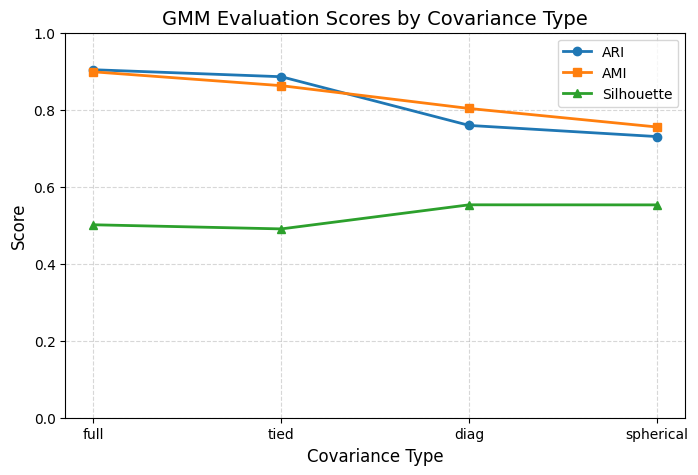

In [38]:
plot_gmm_scores(evaluate_gmm_models(X, y))

- The <i>"full"</i> and <i>"tied"</i> covariance types are better in the **ARI** and **AMI** metrics.
- The <i>"diag"</i> and <i>"spherical"</i> covariance types are better in the **Silhouette** score.

As we earlier said, **ARI** and **AMI** are <i>external clustering validation metrics</i> that favor label agreement, not necessarily geometrical tightness. The **Silhouette** score is an <i>internal clustering validation metric</i> that favors geometrical separation, not label correctness.

- The <i>"diag"</i> and <i>"spherical"</i> covariance types in GMM assume axis-aligned or spherical clusters. If the true clusters are elongated or overlapping, these models produce geometrically “nice” clusters → higher silhouette, but they don’t match the ground truth → lower ARI/AMI.

- The <i>"full"</i> and <i>"tied"</i> covariance types can model elliptical clusters more flexibly. They better match the true labels → higher ARI/AMI, but maybe the clusters are less “compact” geometrically → slightly lower silhouette.

In [39]:
X_scale = X.copy()
X_scale[:, 0] *= 10

In [40]:
evaluate_gmm_models(X_scale, y)

,Covariance Type,ARI,AMI,Silhouette
0,full,0.90387,0.89844,0.23944
1,tied,0.88570,0.86249,0.23137
2,diag,0.81801,0.81070,0.26921
3,spherical,0.37713,0.38193,0.52204


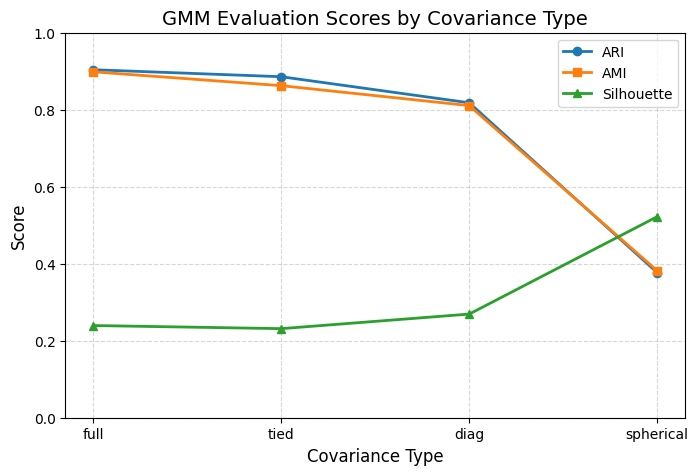

In [41]:
plot_gmm_scores(evaluate_gmm_models(X_scale, y))

After feature scaling, the **ARI** and the **AMI** scores are very low in the <i>"spherical"</i> covariance type, because the spherical covariance is extremely sensitive to feature scales.

If one feature is much larger than others, that dimension dominates distances. And since the GMM tries to fit spheres, the clusters may collapse or misalign, so the ARI/AMI scores drops further.

The **Silhouette** score is high because it is purely distance-based. Even if the spherical GMM does not match the true labels, it can produce compact, roughly spherical clusters. Distances within clusters are small, distances to nearest clusters are large → high silhouette.

ARI/AMI compare to true labels, Even if clusters are geometrically nice, the labels may be “wrong” → low ARI/AMI.